<a href="https://colab.research.google.com/github/realtechsupport/cocktail/blob/main/sandbox/notebooks/inference_tfrecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brief Recap:

1. We have converted the tiff files into tf records and saved them as tf.records in drive
2. We have extracted the saved tf.records and conducted pre-processing.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Phase 1: Extract tf records from the tiff files

In [ ]:
!pip install rasterio

#imports

import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import glob

In [ ]:
#file locations

# Specify the folder path where your images are located
folder_path = '/content/gdrive/MyDrive/exp/other images/test_folder/'

# Specify the folder path where your labels are located
label_folder = '/content/gdrive/MyDrive/exp/label/'

#Specify the path where your clipping mask are located
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'


#specify the tf.record path
output_dir = '/content/gdrive/MyDrive/exp/tf_records/'

Clipping, Resizing, Conversion to tf.record functions

In [ ]:
def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)
        #print(clip_geojson)

    with rasterio.open(tiff) as src:
        #print("input image data before processing", src.meta)

        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)
        #print("shape of clipped_image:", clip_image.shape)
        #print("extent of clipped image:", clip_transform)
        #clip_meta = src.meta.copy()

    # clip_meta.update({"driver": "GTiff",
    #                   "height": clip_image.shape[1],
    #                   "width": clip_image.shape[2],
    #                   "transform": clip_transform})
    return clip_image

# preprocessing functions

def resize_img(image,label):

  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])

  return image, label


def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])

    if tensor_label.shape[:2] != tensor_image.shape[:2]:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    return tensor_image, tensor_label


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(image, label):
    image = clip_tiff(image)
    label = clip_tiff(label)
    image, label = process_input(image, label)
    image_dims = image.shape
    label_dims = label.shape

    image = tf.reshape(image, [-1])  # flatten to 1D array
    label = tf.reshape(label, [-1])  # flatten to 1D array

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _float_feature(image.numpy()),
                "image_shape": _int64_feature(
                    [image_dims[0], image_dims[1], image_dims[2]]
                ),
                "label": _float_feature(label.numpy()),
                "label_shape": _int64_feature([label_dims[0], label_dims[1], label_dims[2]]),
            }
        )
    ).SerializeToString()

In [ ]:
images = glob.glob(folder_path + '*.tif') #list of filelocations of all images

number_of_images = len(images)

labels = glob.glob(label_folder + '*.tif')

labels = labels*number_of_images


In [ ]:
def write_tfrecords2(images, labels, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    for image, label in zip(images, labels):
        output_file = os.path.join(output_directory, f"{image.replace(folder_path,'').replace('.tif','')}_tfrecord.tfrecord")
        #print(output_file)
        with tf.io.TFRecordWriter(output_file) as writer:
            tf_example = create_tfrecord(image, label)
            writer.write(tf_example)


write_tfrecords2(images, labels, output_dir)


In [ ]:
# def create_dataset(tfrecords_dir):
#   tfrecord_files = [os.path.join(input_directory, file) for file in os.listdir(input_directory) if file.endswith('.tfrecord')]
#   dataset = tf.data.TFRecordDataset(tfrecord_files)
#   dataset = dataset.map(parse_tfr)
#   return dataset

# Phase 2: Convert the image-label pair to image-patch and label-patch tensors and prepare to load into model

In [20]:
input_directory = '/content/gdrive/MyDrive/exp/tf_records/'

In [21]:
import tensorflow as tf
import os

In [22]:
feature_description = {
    "image": tf.io.VarLenFeature(tf.float32),
    "image_shape": tf.io.VarLenFeature(tf.int64),
    "label": tf.io.VarLenFeature(tf.float32),
    "label_shape": tf.io.VarLenFeature(tf.int64),
}

def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)


In [23]:
def create_dataset(tfrecords_dir):
  tfrecord_files = [os.path.join(input_directory, file) for file in os.listdir(input_directory) if file.endswith('.tfrecord')]
  dataset = tf.data.TFRecordDataset(tfrecord_files)
  dataset = dataset.map(parse)
  return dataset

In [24]:
#pre-processing functions

def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Convert the input_tensor to a float32 type
    input_tensor = tf.cast(input_tensor, tf.float32)

    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor

def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image

def tile_image(fullimg, CHANNELS=1, TILE_HT=128, TILE_WD=128):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    #print(tiles.shape)

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    #print(tiles.shape)
    tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    print(tiles.shape)
    return tiles

def sampling(label_image, threshold_percentage = 99.9):

    num_zeros = tf.reduce_sum(tf.cast(tf.equal(label_image, 0), tf.float32), axis=[2, 3, 4])

    # Calculate the total number of elements in each patch
    total_elements = tf.cast(tf.reduce_prod(tf.shape(label_image)[2:]), tf.float32)

    # Calculate the percentage of zeros in each patch
    percentage_zeros = (num_zeros / total_elements) * 100.0

    boolean_mask = percentage_zeros <= threshold_percentage
    # Apply the threshold logic
    sampled_tensor = tf.cast(percentage_zeros >= threshold_percentage, tf.int32)

    return boolean_mask, sampled_tensor

def one_hot_encoding(label_tensor):
    # Assuming your pixel values are float labels
    float_labels = tf.squeeze(label_tensor, axis=-1)  # Assuming channel dimension is the last one

    # Determine the number of classes dynamically
    num_classes = tf.cast(tf.reduce_max(float_labels) + 1, tf.int32)

    # One-hot encode each image
    one_hot_encoded_images = tf.one_hot(tf.dtypes.cast(float_labels, tf.int32), depth=num_classes)

    # Print the shape of the resulting tensor and the number of classes
    #print("Shape of one-hot encoded images:", one_hot_encoded_images.shape)
    #print("Number of classes:", num_classes)

    return one_hot_encoded_images


In [25]:
dataset = create_dataset(input_directory)

In [26]:
image_patch_tensors_list = []
label_patch_tensors_list = []

for parsed_example in dataset:

    image_shape = tf.sparse.to_dense(parsed_example["image_shape"])
    image = tf.reshape(tf.sparse.to_dense(parsed_example["image"]), image_shape)
    label_shape = tf.sparse.to_dense(parsed_example["label_shape"])
    label = tf.reshape(tf.sparse.to_dense(parsed_example["label"]), label_shape)

    #image normalization
    image = bandwise_normalize(image)

    #image and label patching
    image_patches = tile_image(image,8,8,8)
    label_patches = tile_image(label,1,8,8)

    #sampling
    sampled_mask, sampled_tensor = sampling(label_patches)
    sampled_image_patches = tf.boolean_mask(image_patches, sampled_mask)
    sampled_label_patches = tf.boolean_mask(label_patches, sampled_mask)

    #one-hot encoding
    sampled_label_patches = one_hot_encoding(sampled_label_patches)

    #save them in the list
    image_patch_tensors_list.append(sampled_image_patches)
    label_patch_tensors_list.append(sampled_label_patches)


# Combine images and labels from different pairs
combined_images = tf.concat(image_patch_tensors_list, axis=0)
combined_labels = tf.concat(label_patch_tensors_list, axis=0)

# Shuffle the combined data
combined_dataset = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels))
combined_dataset = combined_dataset.shuffle(buffer_size=combined_images.shape[0])

#Split the combined dataset into training and validation sets
train_size = int(0.8 * combined_images.shape[0])
train_dataset = combined_dataset.take(train_size)
val_dataset = combined_dataset.skip(train_size)



#Batch the data using TensorFlow's Dataset API
batch_size = None  # Choose an appropriate batch size
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


(462, 573, 8, 8, 8)
(462, 573, 8, 8, 1)
(462, 573, 8, 8, 8)
(462, 573, 8, 8, 1)


ValueError: ignored

In [27]:
#Batch the data using TensorFlow's Dataset API
batch_size = 32  # Choose an appropriate batch size
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Phase 3: train a model with the prepared dataset

In [28]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (8,))
    x = inputs

    # Encoder
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(concat4)
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])
    conv5 = layers.Conv2D(16, 3, activation="relu", padding="same")(concat5)
    conv5 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv5)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(conv5)

    model = keras.Model(inputs, outputs)
    return model

In [29]:
patch_size = 8
img_size = (patch_size, patch_size)
num_classes = 23
model = get_model(img_size=img_size, num_classes=num_classes)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 8)]            0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 16)             1168      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 16)             2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 4, 4, 16)             0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [34]:
model.compile(optimizer="adam", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("patch_8_batch_32.hdf5",
                                    save_best_only=True)
]

model_history = model.fit(train_dataset,
                    epochs=25,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data= val_dataset)

model.save('/content/gdrive/MyDrive/exp/patch_8_batch_32.hdf5')


Epoch 1/25
469/469 [==============================] - 7s 7ms/step - loss: 0.7611 - val_loss: 0.7403
Epoch 2/25
469/469 [==============================] - 3s 7ms/step - loss: 0.7628 - val_loss: 0.7461
Epoch 3/25
469/469 [==============================] - 4s 9ms/step - loss: 0.7528 - val_loss: 0.7150
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.7384 - val_loss: 0.7325
Epoch 5/25
469/469 [==============================] - 3s 7ms/step - loss: 0.7519 - val_loss: 0.7055
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.7478 - val_loss: 0.7326
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.7416 - val_loss: 0.7186
Epoch 8/25
469/469 [==============================] - 3s 7ms/step - loss: 0.7279 - val_loss: 0.7059
Epoch 9/25
469/469 [==============================] - 3s 7ms/step - loss: 0.7392 - val_loss: 0.7747
Epoch 10/25
469/469 [==============================] - 4s 9ms/step - loss: 0.7444 - val_loss: 0.7287

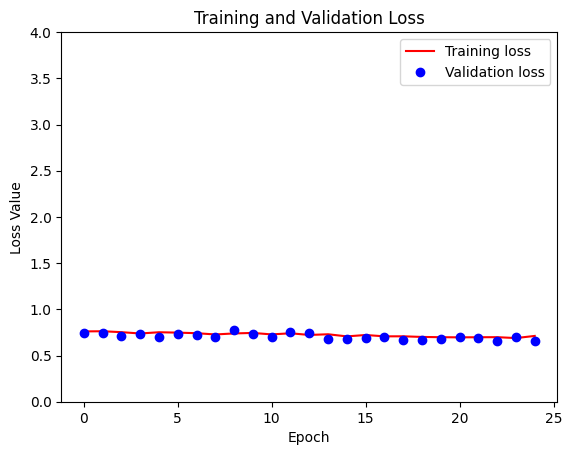

In [37]:
import matplotlib.pyplot as plt

# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = 25
epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 4])
plt.legend()
plt.show()

# Phase 4: Metrics and Evaluation

# Phase 5: Prediction

In [2]:
from tensorflow import keras

model = keras.models.load_model("/content/gdrive/MyDrive/exp/patch_8_batch_32.hdf5")

In [3]:
import os
!pip install rasterio
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys, os

In [4]:
# Specify the folder path where your images are located
test_image_path = '/content/gdrive/MyDrive/exp/other images/test_folder/area2_0619_2023_8bands_composite.tif'


#Specify the path where your clipping mask are located
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'

In [5]:
def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)
        #print(clip_geojson)

    with rasterio.open(tiff) as src:
        #print("input image data before processing", src.meta)

        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)
        #print("shape of clipped_image:", clip_image.shape)
        #print("extent of clipped image:", clip_transform)
        #clip_meta = src.meta.copy()

    # clip_meta.update({"driver": "GTiff",
    #                   "height": clip_image.shape[1],
    #                   "width": clip_image.shape[2],
    #                   "transform": clip_transform})
    return clip_image



def predict_input(image):
    # image = clip_tiff(image)
    ## resizing and process input funciton condensed into one.
    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    return tensor_image

def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Convert the input_tensor to a float32 type
    input_tensor = tf.cast(input_tensor, tf.float32)

    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor

def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image

def tile_image(fullimg, CHANNELS=1, TILE_HT=128, TILE_WD=128):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    print(tiles.shape)

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    print(tiles.shape)
    all_tiles = tf.reshape(tiles, [nrows* ncols, TILE_HT, TILE_WD, CHANNELS])
    ordered_tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    print(all_tiles.shape)
    print(ordered_tiles.shape)
    return ordered_tiles, all_tiles, fullimg.shape

In [6]:
image = clip_tiff(test_image_path)

new_image = predict_input(image)

normalized_image = bandwise_normalize(new_image)

display_patches,inference_patches,dims = tile_image(normalized_image,8,8,8)

(1, 462, 567, 512)
(462, 567, 512)
(261954, 8, 8, 8)
(462, 567, 8, 8, 8)


In [7]:
dims

TensorShape([3696, 4536, 8])

In [ ]:
tiles = display_patches
nrows = tiles.shape[0]
ncols = tiles.shape[1]
f, ax = plt.subplots(nrows, ncols, figsize=(40,20))
for rowno in range(nrows):
    for colno in range(ncols):
        img = tiles[rowno][colno][:, :, -2]
        ax[rowno, colno].imshow( tiles[rowno][colno][:, :, -2].numpy(),cmap='gray'  );
        ax[rowno, colno].axis('off')

In [8]:
predictions = model.predict(inference_patches)

8187/8187 [==============================] - 23s 2ms/step


In [9]:

# Assuming logits is your input tensor of shape (270, 256, 256, 23)
logits = predictions

# Set values of class 0 to a very large negative number
mask = tf.one_hot(0, depth=23, on_value=float('-inf'), off_value=0, dtype=tf.float32)
logits_with_mask = logits + mask

# Perform argmax along the last axis (axis=-1)
argmax_result = tf.argmax(logits_with_mask, axis=-1)

In [12]:
tiles = display_patches

nrows = tiles.shape[0]
ncols = tiles.shape[1]

segmentation_patches = tf.reshape(argmax_result, [nrows, ncols, 8, 8])
#f, ax = plt.subplots(nrows, ncols, figsize=(40,20))

segmented_patches = []
for rowno in range(nrows):
    for colno in range(ncols):
        img = segmentation_patches[rowno][colno]
        segmented_patches.append(img)
        # ax[rowno, colno].imshow( segmentation_patches[rowno][colno].numpy(),cmap='gray');
        # ax[rowno, colno].axis('off')

In [13]:
height= dims[0]
width = dims[1]
patch_size = 8
stitched_array = np.zeros((height,width))
patch_idx = 0
for i in range(0, height, patch_size):
    for j in range(0, width, patch_size):
        patch = segmented_patches[patch_idx]
        stitched_array[i:i+patch_size, j:j+patch_size] = patch
        patch_idx += 1

In [14]:
flattened_array = np.ravel(stitched_array).astype(int)
result = np.bincount(flattened_array)

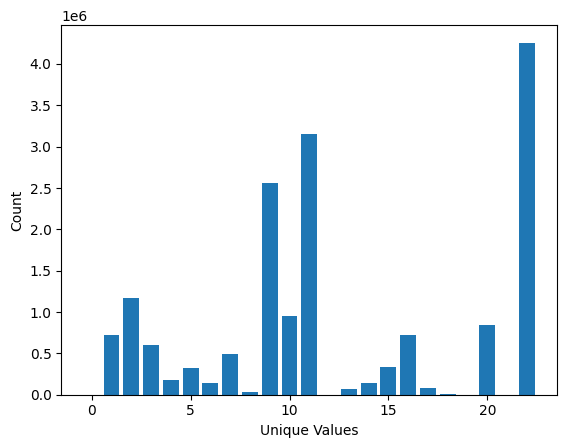

In [15]:


# Generate x-axis values (unique integers in the input array)
x_values = np.arange(len(result))

# Create a bar plot
plt.bar(x_values, result, align='center')

# Label the axes
plt.xlabel('Unique Values')
plt.ylabel('Count')

# Show the plot
plt.show()

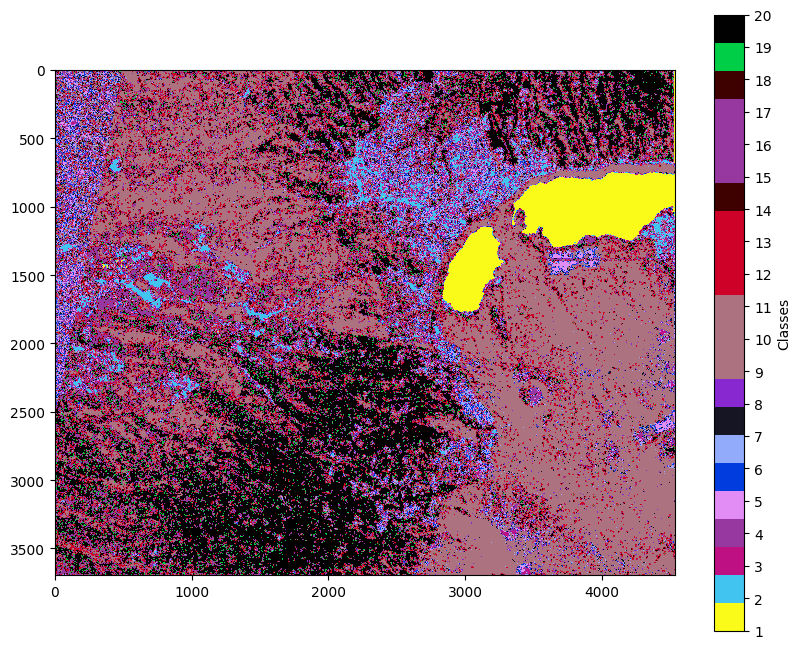

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the class-color mapping
class_colors = {
    1: ( 5, 5, 230),
    2: (190, 60, 15),
    3: (65, 240, 125),
    4: (105, 200, 95),
    5: ( 30, 115, 10),
    6: ( 255, 196, 34),
    7: (110, 85, 5),
    8: ( 235, 235, 220),
    9: (120, 216, 47),
    10: ( 84, 142, 128),
    11: ( 84, 142, 128),
    12: ( 84, 142, 128),
    13: ( 50, 255, 215),
    14: ( 50, 255, 215),
    15: ( 50, 255, 215),
    16: ( 193, 255, 0),
    17: ( 105, 200, 95),
    18: (105, 200, 95),
    19: ( 105, 200, 95),
    20: (193, 255, 0),
    21: ( 255, 50, 185),
    22: (255, 255, 255),
}

# Create a colormap using the class-color mapping
colors = [class_colors[i] for i in range(1, 23)]
cmap = ListedColormap(colors)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))


# Plot the segmentation mask using the custom colormap
image = ax.imshow(stitched_array, cmap=cmap, vmin=1, vmax=20)

# Add a colorbar to show the class-color mapping
cbar = plt.colorbar(image, ax=ax, ticks=list(class_colors.keys()))
cbar.set_label('Classes')

# Show the plot
plt.show()
plt.savefig('/content/segmentation_mask.png')